In [2]:
from pathlib import Path
import pandas as pd

# Path 정리
DATA_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data")
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_mini_sam3/")
CSV_PATH = DATA_DIR / "metadata.csv"

# CSV 불러오기
df = pd.read_csv(CSV_PATH)

target = 0                              # 원하는 행 인덱스 설정
COMMON_PATH = df.loc[0,"common_path"]   # COMMON_PATH 추출

FRAME_DIR = DATA_DIR / "1_FRAME" / COMMON_PATH          # 프레임 디렉토리 경로 설정
KPT_DIR = DATA_DIR / "2_KEYPOINTS" / COMMON_PATH        # 키포인트 디렉토리 경로 설정
MP4_DIR = DATA_DIR / "3_MP4" / f"{COMMON_PATH}.mp4"              # MP4 디렉토리 경로 설정    
INTERP_DIR = DATA_DIR / "4_INTERP_DATA" /COMMON_PATH    # 보간 데이터 디렉토리 경로 설정
OUTPUT_PATH = BASE_DIR / "output.mp4"

# 경로 출력
print(" BASE_DIR:", BASE_DIR,"\n FRAME_DIR:", FRAME_DIR, "\n KPT_DIR:", KPT_DIR, "\n MP4_DIR:", MP4_DIR, "\n INTERP_DIR:", INTERP_DIR)

# 2. 파일 존재 여부 확인 (안전장치)
if not MP4_DIR.exists():
    print(f"⚠️ 경고: 파일을 찾을 수 없습니다 -> {MP4_DIR}")
    # 혹시 파일명이 다를 수도 있으니, glob으로 한 번 더 찾아보는 로직 (선택사항)
    # found = list((DATA_DIR / "3_MP4" / COMMON_PATH).glob("*.mp4"))
    # if found: MP4_DIR = found[0]
else:
    print(f"✅ 타겟 비디오 확인: {MP4_DIR}")


 BASE_DIR: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_mini_sam3 
 FRAME_DIR: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data/1_FRAME/AI_dataset/N01/N01_Treatment/diagonal__biceps_curl 
 KPT_DIR: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data/2_KEYPOINTS/AI_dataset/N01/N01_Treatment/diagonal__biceps_curl 
 MP4_DIR: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data/3_MP4/AI_dataset/N01/N01_Treatment/diagonal__biceps_curl.mp4 
 INTERP_DIR: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data/4_INTERP_DATA/AI_dataset/N01/N01_Treatment/diagonal__biceps_curl
✅ 타겟 비디오 확인: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data/3_MP4/AI_dataset/N01/N01_Treatment/diagonal__biceps_curl.mp4


In [3]:
from pathlib import Path
from sam3.model_builder import build_sam3_video_model
CHECKPOINT_DIR = DATA_DIR / "checkpoints/SAM3"
CHECKPOINT_PT = CHECKPOINT_DIR / "sam3.pt"

sam3_model = build_sam3_video_model(checkpoint_path=CHECKPOINT_PT)  # SAM3 비디오 모델 빌드
predictor = sam3_model.tracker                                      # SAM3 비디오 예측기 초기화
predictor.backbone = sam3_model.detector.backbone                   # 백본 설정

/opt/conda/lib/python3.11/site-packages/sam3/model_builder.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO 2025-12-15 17:15:27,429 1459 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16


: 

In [4]:
# [수정된 코드]
print(f"Loading video from: {str(MP4_DIR)}")

try:
    inference_state = predictor.init_state(
        video_path=str(MP4_DIR),
        
        # [핵심 해결책] 비디오 프레임을 GPU 대신 CPU 메모리에 저장합니다.
        # 속도는 아주 살짝 느려질 수 있지만, 긴 영상도 메모리 부족 없이 처리 가능합니다.
        offload_video_to_cpu=True, 
        
        # (선택 사항) 상태값도 CPU로 보내 메모리를 더 절약하려면 True로 설정하세요.
        offload_state_to_cpu=True, 
        
        # (선택 사항) 비디오 로딩을 비동기로 처리해 속도를 높입니다.
        async_loading_frames=True  
    )
    print("✅ 비디오 로드 성공! (CPU Offloading 적용됨)")

except RuntimeError as e:
    print(f"❌ 여전히 메모리 오류가 발생하면 비디오 길이를 줄이거나 해상도를 낮춰야 합니다.\nError: {e}")

Loading video from: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data/3_MP4/AI_dataset/N01/N01_Treatment/diagonal__biceps_curl.mp4
✅ 비디오 로드 성공! (CPU Offloading 적용됨)


: 

In [5]:
predictor.clear_all_points_in_video(inference_state)

: 

In [6]:
import cv2
# load the frames for visualization
cap = cv2.VideoCapture(str(MP4_DIR))
video_frames_for_vis = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()
frame0 = video_frames_for_vis[0]

width, height = frame0.shape[1], frame0.shape[0]

: 

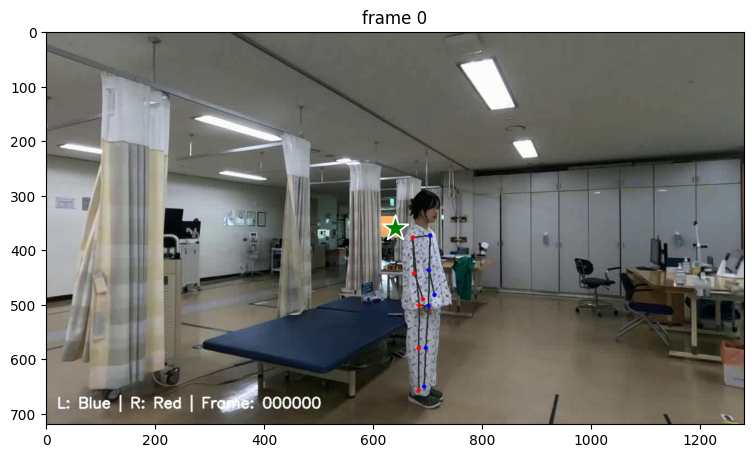

: 

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sam3
from sam3.visualization_utils import show_box, show_mask, show_points

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[640, 360]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)

rel_points = [[x / width, y / height] for x, y in points]

points_tensor = torch.tensor(rel_points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

_, out_obj_ids, low_res_masks, video_res_masks = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_tensor,
    labels=points_labels_tensor,
    clear_old_points=False,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame0)
show_points(points, labels, plt.gca())
show_mask((video_res_masks[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [8]:
import time  # 시간을 다루기 위한 모듈

# 1. 예측(Inference) 시작 시간 기록
print("🚀 Tracking propagation started...")
start_time = time.time()  # 현재 시간을 기록합니다.

# --- [예측 루프] ---
video_segments = {} 
# generator를 통해 프레임별로 추론을 수행합니다.
for frame_idx, obj_ids, low_res_masks, video_res_masks, obj_scores in predictor.propagate_in_video(inference_state, start_frame_idx=0, max_frame_num_to_track=2432, reverse=False, propagate_preflight=True):
    video_segments[frame_idx] = {
        out_obj_id: (video_res_masks[i] > 0.0).cpu().numpy()  # 마스크 이진화
        for i, out_obj_id in enumerate(out_obj_ids)         # 객체 ID 매핑
    }

# 2. 예측 종료 시간 기록 및 계산
end_time = time.time()    # 종료 시간을 기록합니다.
elapsed_time = end_time - start_time  # 차이를 계산합니다 (초 단위).

# 3. 결과 분석 출력
total_frames = len(video_segments)  # 처리된 총 프레임 수
fps = total_frames / elapsed_time if elapsed_time > 0 else 0  # FPS 계산

print("-" * 50)
print(f"✅ Prediction Completed!")
print(f"⏱️  Total Time : {elapsed_time:.4f} seconds")  # 총 소요 시간
print(f"🎞️  Total Frames: {total_frames}")               # 처리한 프레임 수
print(f"🚀  Speed       : {fps:.2f} FPS")                # 초당 처리 프레임 수 (중요!)
print("-" * 50)

🚀 Tracking propagation started...


propagate in video: 100% 2432/2432 [58:31<00:00,  1.44s/it]

--------------------------------------------------
✅ Prediction Completed!
⏱️  Total Time : 3511.8121 seconds
🎞️  Total Frames: 2432
🚀  Speed       : 0.69 FPS
--------------------------------------------------


: 

In [9]:
import json
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm

# ***************************************************************
# 주의: 이 코드는 이전 셀에서 정의된 전역 변수(DATA_DIR, COMMON_PATH, 
#       video_segments)에 의존합니다.
# ***************************************************************

# --- [1. 마스크에서 BBox 추출 헬퍼 함수] ---
def mask_to_bbox(mask: np.ndarray) -> list:
    """
    이진화된 마스크 (H, W 형태의 numpy 배열)에서 BBox 좌표를 추출합니다.
    [x_min, y_min, x_max, y_max] 형태입니다.
    """
    if mask.ndim == 3: 
        mask = mask.squeeze()

    if mask.sum() == 0:
        return [0, 0, 0, 0]

    coords = np.where(mask > 0) 
    
    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()
    
    # [x_min, y_min, x_max, y_max] 형식으로 반환 (+1은 끝 경계 보정)
    return [int(x_min), int(y_min), int(x_max + 1), int(y_max + 1)]


# --- [2. JSON 저장 메인 함수] ---
def save_tracking_segments_to_json(
    segments: dict, 
    data_dir: Path, 
    common_path: str 
):
    """
    video_segments (마스크 결과)를 BBox 기반 JSON 파일로 변환하여 저장합니다.
    최종 경로는 data_dir / "test" / common_path / "000000.json" 입니다.
    """
    
    # 최종 저장 디렉토리 설정: DATA_DIR / "test" / COMMON_PATH
    final_output_dir = data_dir / "test" / common_path
    # 파일명 설정: 000000.json
    json_output_file = final_output_dir / "000000.json"
    
    # 저장 디렉토리 생성
    final_output_dir.mkdir(parents=True, exist_ok=True)
    
    json_data_for_save = {}

    print(f"🔄 JSON 데이터 변환 시작...")
    pbar = tqdm(segments.items(), desc="Extracting BBox and Saving")

    for frame_idx, masks_dict in pbar:
        frame_results = []
        
        for obj_id, mask in masks_dict.items():
            
            # BBox 추출 및 Score 계산
            bbox_coords = mask_to_bbox(mask) 
            score = 1.0 if bbox_coords[2] > bbox_coords[0] else 0.0
            
            frame_results.append({
                "obj_id": int(obj_id),
                "bbox": bbox_coords, # [x_min, y_min, x_max, y_max]
                "score": float(score)
            })

        # 프레임 번호를 키로 사용하여 저장
        json_data_for_save[str(frame_idx)] = frame_results

    pbar.close()

    # JSON 파일로 저장
    with open(json_output_file, 'w') as f:
        json.dump(json_data_for_save, f, indent=4)

    print(f"\n✅ JSON 저장 완료! 파일 경로:\n -> {json_output_file}")


# --- [3. 함수 실행] ---

# (이전에 정의된 전역 변수 사용)
save_tracking_segments_to_json(
    segments=video_segments,
    data_dir=DATA_DIR,        
    common_path=COMMON_PATH   
)

🔄 JSON 데이터 변환 시작...


Extracting BBox and Saving: 100% 2432/2432 [00:09<00:00, 249.16it/s]


✅ JSON 저장 완료! 파일 경로:
 -> /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/data/test/AI_dataset/N01/N01_Treatment/diagonal__biceps_curl/000000.json


: 